In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Imputer, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from fancyimpute import KNN, IterativeImputer
import re
import os

%matplotlib inline

Using TensorFlow backend.


In [2]:
os.getcwd()

'C:\\Users\\Jay\\Documents\\GitHub\\classes\\projects1234\\project_2\\code'

In [114]:
ames_train_raw = pd.read_csv('../datasets/train.csv')
ames_test_raw = pd.read_csv('../datasets/test.csv')

In [148]:
missing = ames_train_raw.isnull().sum()[ames_train_raw.isnull().sum() > 0].index.to_list()

In [149]:
ames_train_raw[missing].dtypes

Lot Frontage      float64
Alley              object
Mas Vnr Type       object
Mas Vnr Area      float64
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
BsmtFin Type 1     object
BsmtFin SF 1      float64
BsmtFin Type 2     object
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Bsmt Full Bath    float64
Bsmt Half Bath    float64
Fireplace Qu       object
Garage Type        object
Garage Yr Blt     float64
Garage Finish      object
Garage Cars       float64
Garage Area       float64
Garage Qual        object
Garage Cond        object
Pool QC            object
Fence              object
Misc Feature       object
dtype: object

In [150]:
na_cat = {k:'MISSING' for k in ames_train_raw[missing].dtypes[ames_train_raw[missing].dtypes == 'object'].index}

In [165]:
na_num = {x:-1 for x in missing if x not in na_cat}

In [166]:
na_num

{'Lot Frontage': -1,
 'Mas Vnr Area': -1,
 'BsmtFin SF 1': -1,
 'BsmtFin SF 2': -1,
 'Bsmt Unf SF': -1,
 'Total Bsmt SF': -1,
 'Bsmt Full Bath': -1,
 'Bsmt Half Bath': -1,
 'Garage Yr Blt': -1,
 'Garage Cars': -1,
 'Garage Area': -1}

In [167]:
ames_train_missing = ames_train_raw.copy()
ames_train_missing.fillna(na_cat,axis=0,inplace=True)
ames_train_missing.fillna(na_num,axis=0,inplace=True)

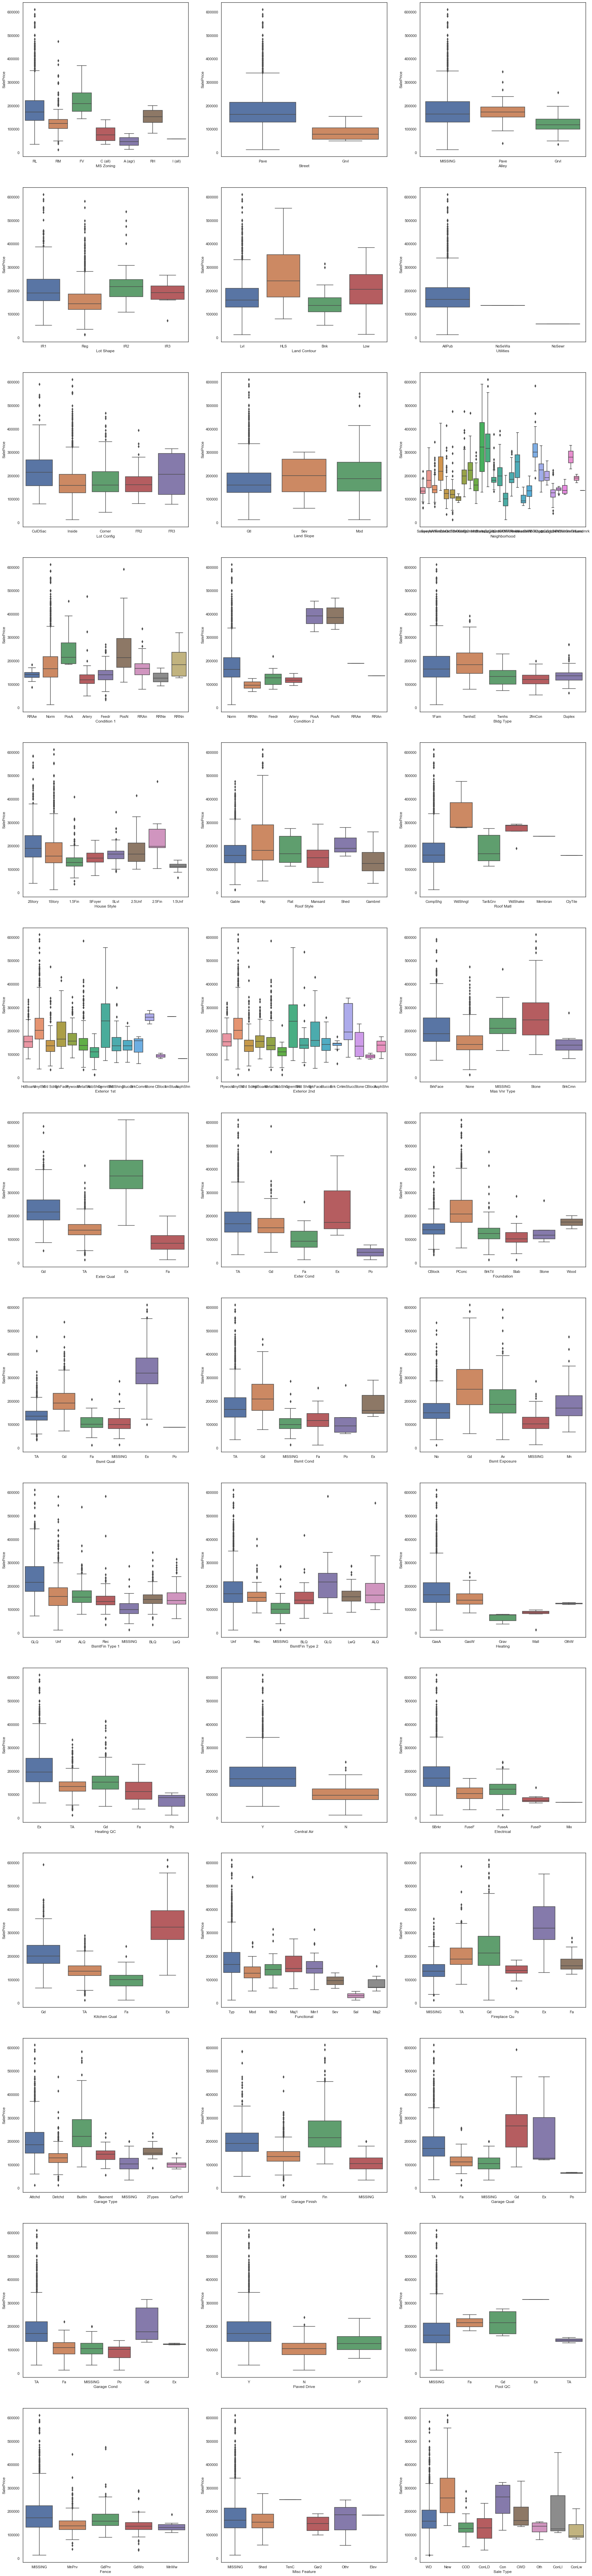

In [168]:
def boxplotter(df,y):
    cat = df.dtypes[df.dtypes == 'object'].index.to_list()
    ncols = 3
    nrows = int(np.ceil(len(cat)/ncols))
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,10*nrows))
    ax = ax.ravel()
    for i, col in enumerate(cat):
        sns.boxplot(x=col,y=y,data=df,ax=ax[i])
    for i in range(len(ax)):
        if i not in range(len(cat)):
            ax[i].axis('off')
            
boxplotter(ames_train_missing,'SalePrice')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C20DA9F128>,
      dtype=object)

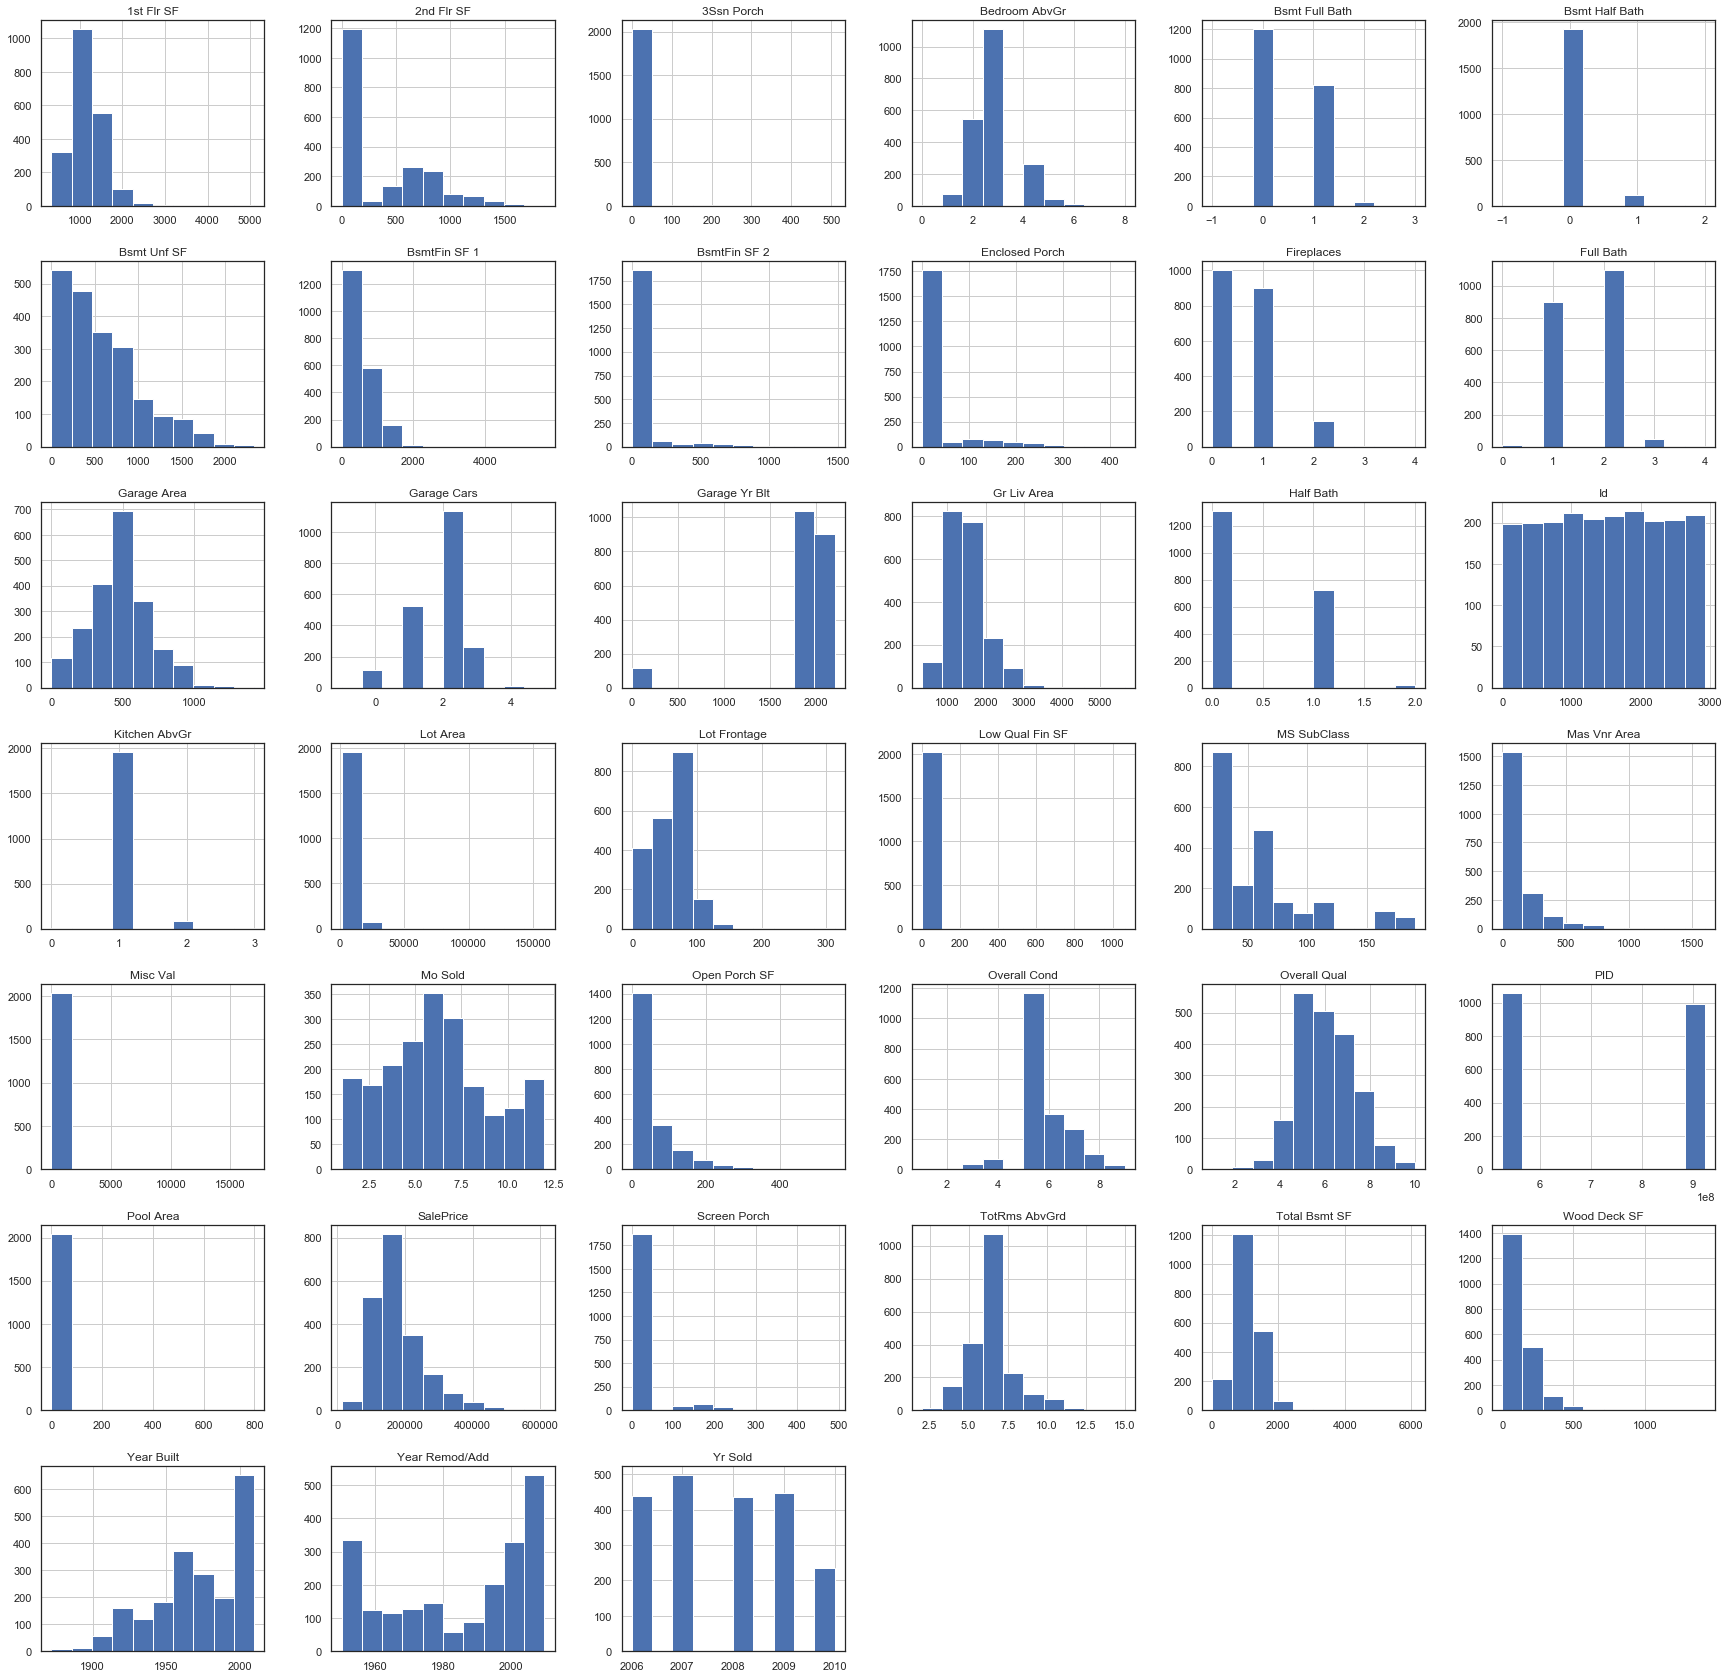

In [169]:
ames_train_missing.hist(figsize=(30,30))

In [4]:
[x for x in ames_train_raw.columns.to_list() if not x in ames_test_raw.columns.to_list()]

['SalePrice']

In [5]:
ames_combined = pd.concat([ames_train_raw.drop(['SalePrice'],axis=1),ames_test_raw],axis=0,ignore_index=True)

In [6]:
ames_combined.shape

(2930, 80)

In [7]:
ames_combined.isnull().sum()[ames_combined.isnull().sum()>0]

Lot Frontage       490
Alley             2732
Mas Vnr Type        23
Mas Vnr Area        23
Bsmt Qual           80
Bsmt Cond           80
Bsmt Exposure       83
BsmtFin Type 1      80
BsmtFin SF 1         1
BsmtFin Type 2      81
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Electrical           1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual        159
Garage Cond        159
Pool QC           2917
Fence             2358
Misc Feature      2824
dtype: int64

In [8]:
ames_combined.dtypes.value_counts()

object     42
int64      27
float64    11
dtype: int64

In [106]:
ames_combined.filter(regex='Year|Yr',axis=1).head()

Year Built  Year Remod/Add  Garage Yr Blt  Yr Sold
0        1976            2005         1976.0     2010
1        1996            1997         1997.0     2009
2        1953            2007         1953.0     2010
3        2006            2007         2007.0     2010
4        1900            1993         1957.0     2010

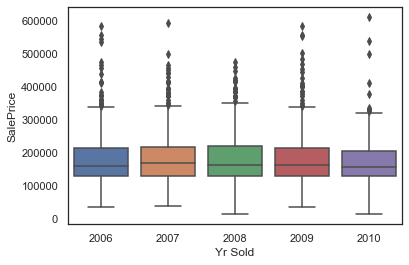

In [113]:
sns.boxplot(x='Yr Sold',y='SalePrice',data=ames_train_imputed)

In [102]:
#drop Id, PID
#change into Nominal: MS SubClass
#change Year Built into age using Yr Sold
#can also create indicator for whether it has been remodeled before
#create age since remodeled
#create garage age and then bin it so that not having a garage is 0
ames_combined.dtypes[ames_combined.dtypes!='object'].index

Index(['Id', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold'],
      dtype='object')

In [9]:
ames_combined.dtypes[ames_combined.dtypes=='object'].index

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type'],
      dtype='object')

In [10]:
# defining the ordinals so that we can use OrdinalEncoder later

ordinals = ['Lot Shape','Utilities','Land Slope','Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Qual'
           ,'Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFinType 2','HeatingQC','Electrical','KitchenQual','Functional',
           'FireplaceQu','Garage Finish','Garage Qual','Garage Cond','Paved Drive','Pool QC','Fence']

In [11]:
ames_combined.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [12]:
# so we see feature names that are discrepancies against the given data dictionary

[x for x in ordinals if not x in ames_combined.columns]

['BsmtFinType 2', 'HeatingQC', 'KitchenQual', 'FireplaceQu']

In [13]:
# rename according to the loaded dataframe

ordinals = ['Lot Shape','Utilities','Land Slope','Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Qual'
           ,'Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Electrical','Kitchen Qual','Functional',
           'Fireplace Qu','Garage Finish','Garage Qual','Garage Cond','Paved Drive','Pool QC','Fence']

In [14]:
# check if our work here is complete

[x for x in ordinals if not x in ames_combined.columns]

[]

In [15]:
[x for x in ordinals if not x in ames_combined.dtypes[ames_combined.dtypes=='object'].index]
#so we know these 2 aren't wrongly labeled

['Overall Qual', 'Overall Cond']

In [101]:
[x for x in ames_combined.columns if x not in ordinals]

['Id',
 'PID',
 'MS SubClass',
 'MS Zoning',
 'Lot Frontage',
 'Lot Area',
 'Street',
 'Alley',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Year Built',
 'Year Remod/Add',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Foundation',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Heating',
 'Central Air',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Type',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Feature',
 'Misc Val',
 'Mo Sold',
 'Yr Sold',
 'Sale Type']

In [16]:
ordinal_dict = {col:ames_combined[col].unique().tolist() for col in ordinals}
ordinal_dict

{'Lot Shape': ['IR1', 'Reg', 'IR2', 'IR3'],
 'Utilities': ['AllPub', 'NoSeWa', 'NoSewr'],
 'Land Slope': ['Gtl', 'Sev', 'Mod'],
 'Overall Qual': [6, 7, 5, 8, 10, 4, 9, 3, 2, 1],
 'Overall Cond': [8, 5, 7, 6, 3, 9, 2, 4, 1],
 'Exter Qual': ['Gd', 'TA', 'Ex', 'Fa'],
 'Exter Cond': ['TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'Bsmt Qual': ['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'],
 'Bsmt Cond': ['TA', 'Gd', nan, 'Fa', 'Po', 'Ex'],
 'Bsmt Exposure': ['No', 'Gd', 'Av', nan, 'Mn'],
 'BsmtFin Type 1': ['GLQ', 'Unf', 'ALQ', 'Rec', nan, 'BLQ', 'LwQ'],
 'BsmtFin Type 2': ['Unf', 'Rec', nan, 'BLQ', 'GLQ', 'LwQ', 'ALQ'],
 'Heating QC': ['Ex', 'TA', 'Gd', 'Fa', 'Po'],
 'Electrical': ['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan],
 'Kitchen Qual': ['Gd', 'TA', 'Fa', 'Ex', 'Po'],
 'Functional': ['Typ', 'Mod', 'Min2', 'Maj1', 'Min1', 'Sev', 'Sal', 'Maj2'],
 'Fireplace Qu': [nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'],
 'Garage Finish': ['RFn', 'Unf', 'Fin', nan],
 'Garage Qual': ['TA', 'Fa', nan, 'Gd', 'Ex', 'Po'],
 'Garage C

In [17]:
ordinal_dict['Lot Shape']=['Reg','IR1','IR2','IR3'][::-1]
ordinal_dict['Utilities']=['AllPub', 'NoSewr','NoSeWa','ELO'][::-1]
ordinal_dict['Land Slope']=['Sev','Mod','Gtl']
ordinal_dict['Overall Qual']=list(range(1,11))
ordinal_dict['Overall Cond']=list(range(1,11))
ordinal_dict['Exter Qual']=['Po','Fa', 'TA','Gd', 'Ex']
ordinal_dict['Exter Cond']=['Po','Fa', 'TA','Gd', 'Ex']
ordinal_dict['Bsmt Qual']=['NA','Po','Fa', 'TA','Gd', 'Ex']
ordinal_dict['Bsmt Cond']=['NA','Po','Fa', 'TA','Gd', 'Ex']
ordinal_dict['Bsmt Exposure']=['NA', 'No', 'Mn', 'Av', 'Gd']
ordinal_dict['BsmtFin Type 1']=['NA','Unf', 'LwQ', 'Rec', 'BLQ','ALQ' , 'GLQ']
ordinal_dict['BsmtFin Type 2']=['NA','Unf', 'LwQ', 'Rec', 'BLQ','ALQ' , 'GLQ']
ordinal_dict['Heating QC']=['Po','Fa', 'TA','Gd', 'Ex']
ordinal_dict['Electrical']=['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'][::-1]
ordinal_dict['Kitchen Qual']=['Po','Fa', 'TA','Gd', 'Ex']
ordinal_dict['Functional']=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
ordinal_dict['Fireplace Qu']=['NA','Po','Fa', 'TA','Gd', 'Ex']
ordinal_dict['Garage Finish']=['Fin', 'RFn', 'Unf', 'NA'][::-1]
ordinal_dict['Garage Qual']=['NA','Po','Fa', 'TA','Gd', 'Ex']
ordinal_dict['Garage Cond']=['NA','Po','Fa', 'TA','Gd', 'Ex']
ordinal_dict['Paved Drive']=['Y', 'P', 'N'][::-1]
ordinal_dict['Pool QC']=['NA','Fa', 'TA','Gd', 'Ex']
ordinal_dict['Fence']=['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'][::-1]

In [18]:
ordinal_dict

{'Lot Shape': ['IR3', 'IR2', 'IR1', 'Reg'],
 'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
 'Land Slope': ['Sev', 'Mod', 'Gtl'],
 'Overall Qual': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Overall Cond': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Exter Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'Exter Cond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'Bsmt Qual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'Bsmt Cond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'Bsmt Exposure': ['NA', 'No', 'Mn', 'Av', 'Gd'],
 'BsmtFin Type 1': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'BsmtFin Type 2': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 'Heating QC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
 'Kitchen Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
 'Fireplace Qu': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 'Garage Finish': ['NA', 'Unf', 'RFn', 'Fin'],
 'Garage Qual': ['NA', 'Po', 'Fa', 'TA', 'Gd

In [19]:
ames_train_raw.isnull().sum()[ames_train_raw.isnull().sum()>0]

Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

In [20]:
ames_train_raw.shape

(2051, 81)

In [21]:
ames_train_raw.dtypes.value_counts()

object     42
int64      28
float64    11
dtype: int64

In [22]:
ames_train_raw['Alley'].value_counts()

Grvl    85
Pave    55
Name: Alley, dtype: int64

In [23]:
ames_train_clean = ames_train_raw.fillna({'Alley':'No'},axis=0)

In [24]:
ames_train_clean.isnull().sum()[ames_train_clean.isnull().sum()>0]

Lot Frontage       330
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

In [25]:
ames_train_clean[ames_train_clean['Lot Frontage'].isnull()].head(5).T

0          7          8          23         27
Id                    109        145       1942         12       1534
PID             533352170  535154050  535353130  527165230  909277040
MS SubClass            60         20         20         20         50
MS Zoning              RL         RL         RL         RL         RL
Lot Frontage          NaN        NaN        NaN        NaN        NaN
Lot Area            13517      12160      15783       7980      11700
Street               Pave       Pave       Pave       Pave       Pave
Alley                  No         No         No         No       Grvl
Lot Shape             IR1        IR1        Reg        IR1        IR1
Land Contour          Lvl        Lvl        Lvl        Lvl        HLS
Utilities          AllPub     AllPub     AllPub     AllPub     AllPub
Lot Config        CulDSac     Inside     Inside     Inside     Inside
Land Slope            Gtl        Gtl        Gtl        Gtl        Mod
Neighborhood       Sawyer      NAmes    OldTown    Gilbert    Crawfor
Condition 1          RRAe       Norm     Artery       Norm       Norm
Condition 2          Norm       Norm       Norm       Norm       Norm
Bldg Type            1Fam       1Fam       1Fam       1Fam       1Fam
House Style        2Story     1Story     1Story     1Story     1.5Fin
Overall Qual            6          5          5          6          5
Overall Cond            8          5          5          7          6
Year Built           1976       1959       1952       1992       1937
Year Remod/Add       2005       1959       1952       2007       1995
Roof Style          Gable        Hip      Gable      Gable      Gable
Roof Matl         CompShg    CompShg    CompShg    CompShg    CompShg
Exterior 1st      HdBoard    Plywood    Wd Sdng    HdBoard    WdShing
Exterior 2nd      Plywood    Plywood    Wd Sdng    HdBoard    Wd Shng
Mas Vnr Type      BrkFace    BrkFace       None       None       None
Mas Vnr Area          289        180          0          0          0
Exter Qual             Gd         TA         TA         TA         TA
Exter Cond             TA         TA         TA         Gd         TA
...                   ...        ...        ...        ...        ...
Half Bath               1          0          0          0          0
Bedroom AbvGr           3          3          2          3          4
Kitchen AbvGr           1          1          1          1          1
Kitchen Qual           Gd         TA         TA         TA         Gd
TotRms AbvGrd           6          6          6          6          7
Functional            Typ        Typ        Typ        Typ       Min2
Fireplaces              0          0          0          0          1
Fireplace Qu          NaN        NaN        NaN        NaN         Gd
Garage Type        Attchd     Attchd     Detchd     Attchd     Detchd
Garage Yr Blt        1976       1959       1952       1992       1937
Garage Finish         RFn        RFn        Unf        Fin        Unf
Garage Cars             2          2          1          2          1
Garage Area           475        531        420        420        240
Garage Qual            TA         TA         TA         TA         TA
Garage Cond            TA         TA         TA         TA         TA
Paved Drive             Y          Y          Y          Y          Y
Wood Deck SF            0          0          0        483          0
Open Porch SF          44          0        324         21         40
Enclosed Porch          0          0          0          0          0
3Ssn Porch              0          0          0          0          0
Screen Porch            0          0          0          0          0
Pool Area               0          0          0          0          0
Pool QC               NaN        NaN        NaN        NaN        NaN
Fence                 NaN      MnPrv      MnPrv      GdPrv        NaN
Misc Feature          NaN        NaN       Shed       Shed        NaN
Misc Val                0        

In [26]:
ames_train_clean['PID'].nunique() #clearly useless, should drop, but keeping it for cleaning purposes until I don't need it

2051

In [27]:
ames_train_clean['Id'].nunique() #ditto

2051

In [28]:
ames_train_clean['Street'].value_counts()

Pave    2044
Grvl       7
Name: Street, dtype: int64

In [29]:
style = ['MS SubClass','House Style']

In [30]:
style.extend([bsmt for bsmt in ames_train_clean.columns.to_list() if 'Bsmt' in bsmt])

In [31]:
style

['MS SubClass',
 'House Style',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'BsmtFin Type 2',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Bsmt Full Bath',
 'Bsmt Half Bath']

In [32]:
ames_train_clean[(~ames_train_clean['Bsmt Qual'].isnull()) & (ames_train_clean['Bsmt Exposure'].isnull())]\
[style].T # wouldn't be farfetched to think the NaN ought to be No

1456    1547    1997
MS SubClass         60      20      60
House Style     2Story  1Story  2Story
Bsmt Qual           Gd      Gd      Gd
Bsmt Cond           TA      TA      TA
Bsmt Exposure      NaN     NaN     NaN
BsmtFin Type 1     Unf     Unf     Unf
BsmtFin SF 1         0       0       0
BsmtFin Type 2     Unf     Unf     Unf
BsmtFin SF 2         0       0       0
Bsmt Unf SF        725    1595     936
Total Bsmt SF      725    1595     936
Bsmt Full Bath       0       0       0
Bsmt Half Bath       0       0       0

In [33]:
ames_train_clean.iloc[[1456,1547,1997],ames_train_clean.columns.to_list().index('Bsmt Exposure')] = 'No'

In [34]:
ames_train_clean.isnull().sum()[ames_train_clean.isnull().sum()>0]

Lot Frontage       330
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       55
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

In [35]:
ames_train_clean[ames_train_clean['BsmtFin SF 1'].isnull()][[x for x in ames_train_clean.isnull() if 'Bsmt' in x]].T
# clearly this should be filled in as NA, No, 0 etc

1327
Bsmt Qual       NaN
Bsmt Cond       NaN
Bsmt Exposure   NaN
BsmtFin Type 1  NaN
BsmtFin SF 1    NaN
BsmtFin Type 2  NaN
BsmtFin SF 2    NaN
Bsmt Unf SF     NaN
Total Bsmt SF   NaN
Bsmt Full Bath  NaN
Bsmt Half Bath  NaN

In [36]:
ames_train_clean.loc[1327,[x for x in ames_train_clean.isnull() if ('Bsmt' in x and 'SF' not in x and 'Bath' not in x)]] = 'NA'

In [37]:
ames_train_clean[(ames_train_clean['BsmtFin Type 2'].isnull()) & ~(ames_train_clean['BsmtFin Type 1'].isnull())][[x for x in ames_train_clean.isnull() if 'Bsmt' in x]].T
#probably a mistake, use Type 1 as proxy

1147
Bsmt Qual         Gd
Bsmt Cond         TA
Bsmt Exposure     No
BsmtFin Type 1   GLQ
BsmtFin SF 1    1124
BsmtFin Type 2   NaN
BsmtFin SF 2     479
Bsmt Unf SF     1603
Total Bsmt SF   3206
Bsmt Full Bath     1
Bsmt Half Bath     0

In [38]:
ames_train_clean[(ames_train_clean['Bsmt Qual']=='Gd') & (ames_train_clean['Bsmt Cond']=='TA') &
                 (ames_train_clean['Bsmt Exposure']=='No') & (ames_train_clean['BsmtFin Type 1']=='GLQ')]['BsmtFin Type 2'].value_counts()

Unf    180
ALQ      4
Rec      3
LwQ      2
BLQ      1
Name: BsmtFin Type 2, dtype: int64

In [39]:
ames_train_clean.loc[1147,'BsmtFin Type 2'] = 'Unf'

In [40]:
ames_train_clean.isnull().sum()[ames_train_clean.isnull().sum()>0]

Lot Frontage       330
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           54
Bsmt Cond           54
Bsmt Exposure       54
BsmtFin Type 1      54
BsmtFin SF 1         1
BsmtFin Type 2      54
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

In [41]:
ames_train_clean[ames_train_clean['BsmtFin SF 1'].isnull()]\
[[x for x in ames_train_clean.isnull() if ('Bsmt' in x and 'SF' in x)]].T
# clearly this should be filled in as NA, No, 0 etc

1327
BsmtFin SF 1    NaN
BsmtFin SF 2    NaN
Bsmt Unf SF     NaN
Total Bsmt SF   NaN

In [42]:
ames_train_clean.loc[1327,[x for x in ames_train_clean.isnull() if ('Bsmt' in x and 'SF' in x)]] = 0

In [43]:
ames_train_clean.isnull().sum()[ames_train_clean.isnull().sum()>0]

Lot Frontage       330
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           54
Bsmt Cond           54
Bsmt Exposure       54
BsmtFin Type 1      54
BsmtFin Type 2      54
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

In [44]:
ames_train_clean[ames_train_clean['Bsmt Full Bath'].isnull()][[x for x in ames_train_clean.isnull() if 'Bsmt' in x]].T
# clearly this should be filled in as NA, No, 0 etc

616  1327
Bsmt Qual       NaN   NA
Bsmt Cond       NaN   NA
Bsmt Exposure   NaN   NA
BsmtFin Type 1  NaN   NA
BsmtFin SF 1      0    0
BsmtFin Type 2  NaN   NA
BsmtFin SF 2      0    0
Bsmt Unf SF       0    0
Total Bsmt SF     0    0
Bsmt Full Bath  NaN  NaN
Bsmt Half Bath  NaN  NaN

In [45]:
ames_train_clean.loc[616,[x for x in ames_train_clean.isnull() if ('Bsmt' in x and 'SF' not in x and 'Bath' not in x)]] = 'NA'
ames_train_clean.loc[[616,1327],[x for x in ames_train_clean.isnull() if 'Bsmt' in x and 'Bath' in x]] = 'NA'

In [46]:
ames_train_clean.isnull().sum()[ames_train_clean.isnull().sum()>0]

Lot Frontage       330
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           53
Bsmt Cond           53
Bsmt Exposure       53
BsmtFin Type 1      53
BsmtFin Type 2      53
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

In [47]:
ames_train_clean[ames_train_clean['Bsmt Qual'].isnull()][[x for x in ames_train_clean.isnull() if 'Bsmt' in x]].isnull().sum()

Bsmt Qual         53
Bsmt Cond         53
Bsmt Exposure     53
BsmtFin Type 1    53
BsmtFin SF 1       0
BsmtFin Type 2    53
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
Bsmt Full Bath     0
Bsmt Half Bath     0
dtype: int64

In [48]:
ames_train_clean.loc[ames_train_clean['Bsmt Qual'].isnull(),[x for x in ames_train_clean.isnull() if ('Bsmt' in x and \
                                                                                             'SF' not in x and \
                                                                                             'Bath' not in x)]] = 'NA'

In [49]:
ames_train_clean[(ames_train_clean['Mas Vnr Type'].isnull()) & (ames_train_clean['Mas Vnr Area'].isnull())][['Exterior 1st','Exterior 2nd']].apply(np.sum,axis=1).value_counts()

VinylSdVinylSd    17
CemntBdCmentBd     3
WdShingWd Shng     1
Wd SdngStone       1
dtype: int64

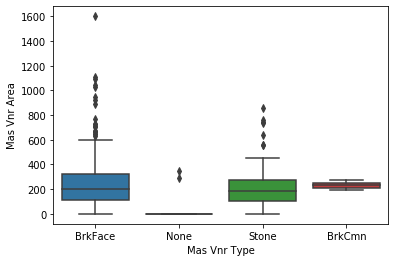

In [50]:
sns.boxplot(x='Mas Vnr Type', y='Mas Vnr Area',
            data=ames_train_clean[(ames_train_clean['Exterior 1st'] == 'VinylSd') & (ames_train_clean['Exterior 2nd']=='VinylSd')])

In [51]:
ames_train_clean[(ames_train_clean['Mas Vnr Type'] == 'None') &
                (ames_train_clean['Mas Vnr Area'] != 0)][[x for x in ames_train_clean.isnull() if 'Mas' in x]]
#observe that for idx 765, 1148, 1684 the Mas Vnr Area should likely just be 0, although we should investigate Mas Vnr Area = 1
#for 810 and 1832, we should fill in the missing values, but what's the proper proxy? MICE in R would have been able to fill in
#categorical. Implementation isn't in Python yet.

Mas Vnr Type  Mas Vnr Area
765          None           1.0
810          None         288.0
1148         None           1.0
1684         None           1.0
1832         None         344.0

In [52]:
ames_train_clean[ames_train_clean['Mas Vnr Area']==1][[x for x in ames_train_clean if 'Mas' in x]]
# same entries, so change to 0

Mas Vnr Type  Mas Vnr Area
765          None           1.0
1148         None           1.0
1684         None           1.0

In [53]:
ames_train_clean.loc[[765,1148,1684],'Mas Vnr Area'] = 0

In [54]:
ames_train_clean[(ames_train_clean['Mas Vnr Area'].isnull()) & (ames_train_clean['Mas Vnr Type'].isnull())].shape
#set all area to 0 and Type to None

(22, 81)

In [55]:
ames_train_clean.fillna({'Mas Vnr Area':0,'Mas Vnr Type':'None'},axis=0,inplace=True)

In [86]:
ames_train_clean[(ames_train_clean['Mas Vnr Area'] != 0) & (ames_train_clean['Mas Vnr Type'] == 'None')][[x for x in ames_train_clean if 'Mas' in x]]

Mas Vnr Type  Mas Vnr Area
810          None         288.0
1832         None         344.0

In [56]:
ames_train_clean.isnull().sum()[ames_train_clean.isnull().sum()>0]

Lot Frontage      330
Fireplace Qu     1000
Garage Type       113
Garage Yr Blt     114
Garage Finish     114
Garage Cars         1
Garage Area         1
Garage Qual       114
Garage Cond       114
Pool QC          2042
Fence            1651
Misc Feature     1986
dtype: int64

In [57]:
ames_train_clean['Fireplace Qu'].value_counts()

Gd    523
TA    407
Fa     59
Ex     31
Po     31
Name: Fireplace Qu, dtype: int64

In [58]:
ames_train_clean[ames_train_clean['Fireplace Qu'].isnull()][[x for x in ames_train_clean if 'Fireplace' in x]].mean()
# all the np.nan should be changed to 'NA'

Fireplaces      0.0
Fireplace Qu    NaN
dtype: float64

In [59]:
ames_train_clean.fillna({'Fireplace Qu':'NA'},axis=0,inplace=True)

In [60]:
ames_train_clean[ames_train_clean['Garage Type'].isnull()][[x for x in ames_train_clean if 'Garage' in x]].isnull().sum()

Garage Type      113
Garage Yr Blt    113
Garage Finish    113
Garage Cars        0
Garage Area        0
Garage Qual      113
Garage Cond      113
dtype: int64

In [61]:
ames_train_clean[ames_train_clean['Garage Type'].isnull()][[x for x in ames_train_clean if 'Garage' in x]].sum()
# fill Garage Yr Blt with mean and the rest with na, none, 0, etc since we can see that Garage Cars and Garage Area are both 0
# but we should investigate the row where type isn't np.nan but the rest are.

Garage Type      0.0
Garage Yr Blt    0.0
Garage Finish    0.0
Garage Cars      0.0
Garage Area      0.0
Garage Qual      0.0
Garage Cond      0.0
dtype: float64

In [62]:
ames_train_clean[ames_train_clean['Garage Cars'].isnull()][[x for x in ames_train_clean if 'Garage' in x]]

Garage Type  Garage Yr Blt Garage Finish  Garage Cars  Garage Area  \
1712      Detchd            NaN           NaN          NaN          NaN   

     Garage Qual Garage Cond  
1712         NaN         NaN

In [63]:
ames_train_clean['Garage Type'].value_counts()

Attchd     1213
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64

In [64]:
ames_train_clean[ames_train_clean['Garage Type']=='Detchd'][[x for x in ames_train_clean if 'Garage' in x]].mode()

Garage Type  Garage Yr Blt Garage Finish  Garage Cars  Garage Area  \
0      Detchd         1920.0           Unf          2.0        576.0   
1         NaN         1930.0           NaN          NaN          NaN   

  Garage Qual Garage Cond  
0          TA          TA  
1         NaN         NaN

In [65]:
ames_train_clean.loc[1712,['Garage Yr Blt','Garage Finish','Garage Cars','Garage Area','Garage Qual','Garage Cond']] = \
[1920,'Unf','2','576','TA','TA']

In [66]:
ames_train_clean.fillna({'Garage Type':'NA','Garage Yr Blt':ames_train_clean['Garage Yr Blt'].mean(),
                        'Garage Finish':'NA','Garage Cars':0,'Garage Area':0,'Garage Qual':'NA',
                        'Garage Cond':'NA'},axis=0,inplace=True)

In [67]:
ames_train_clean.isnull().sum()[ames_train_clean.isnull().sum()>0]

Lot Frontage     330
Pool QC         2042
Fence           1651
Misc Feature    1986
dtype: int64

In [68]:
ames_train_clean[ames_train_clean['Pool Area'] != 0][['Pool Area','Pool QC']]

Pool Area Pool QC
52          519      Fa
657         576      Gd
761         800      Gd
952         228      Ex
960         480      Gd
1130        648      Fa
1249        738      Gd
1635        368      TA
1875        561      TA

In [69]:
ames_train_clean[ames_train_clean['Pool Area'] != 0][['Pool Area','Pool QC']].shape

(9, 2)

In [70]:
ames_train_clean['Pool QC'].value_counts()

Gd    4
Fa    2
TA    2
Ex    1
Name: Pool QC, dtype: int64

In [71]:
ames_train_clean.fillna({'Pool QC':'NA'},axis=0,inplace=True)

In [72]:
ames_train_clean[ames_train_clean['Misc Feature'].isnull()]['Misc Val'].sum()
# can set to 'NA' for 'Misc Feature'

0

In [73]:
ames_train_clean.fillna({'Misc Feature':'NA'},axis=0,inplace=True)

In [74]:
ames_train_clean.isnull().sum()[ames_train_clean.isnull().sum()>0]
#gonna try and use KNN imputation

Lot Frontage     330
Fence           1651
dtype: int64

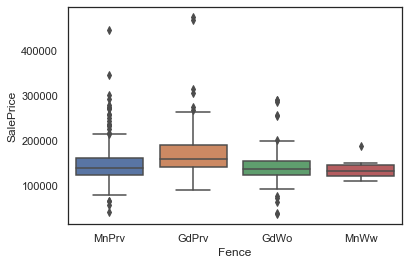

In [87]:
sns.boxplot(x='Fence',y='SalePrice',data=ames_train_clean)

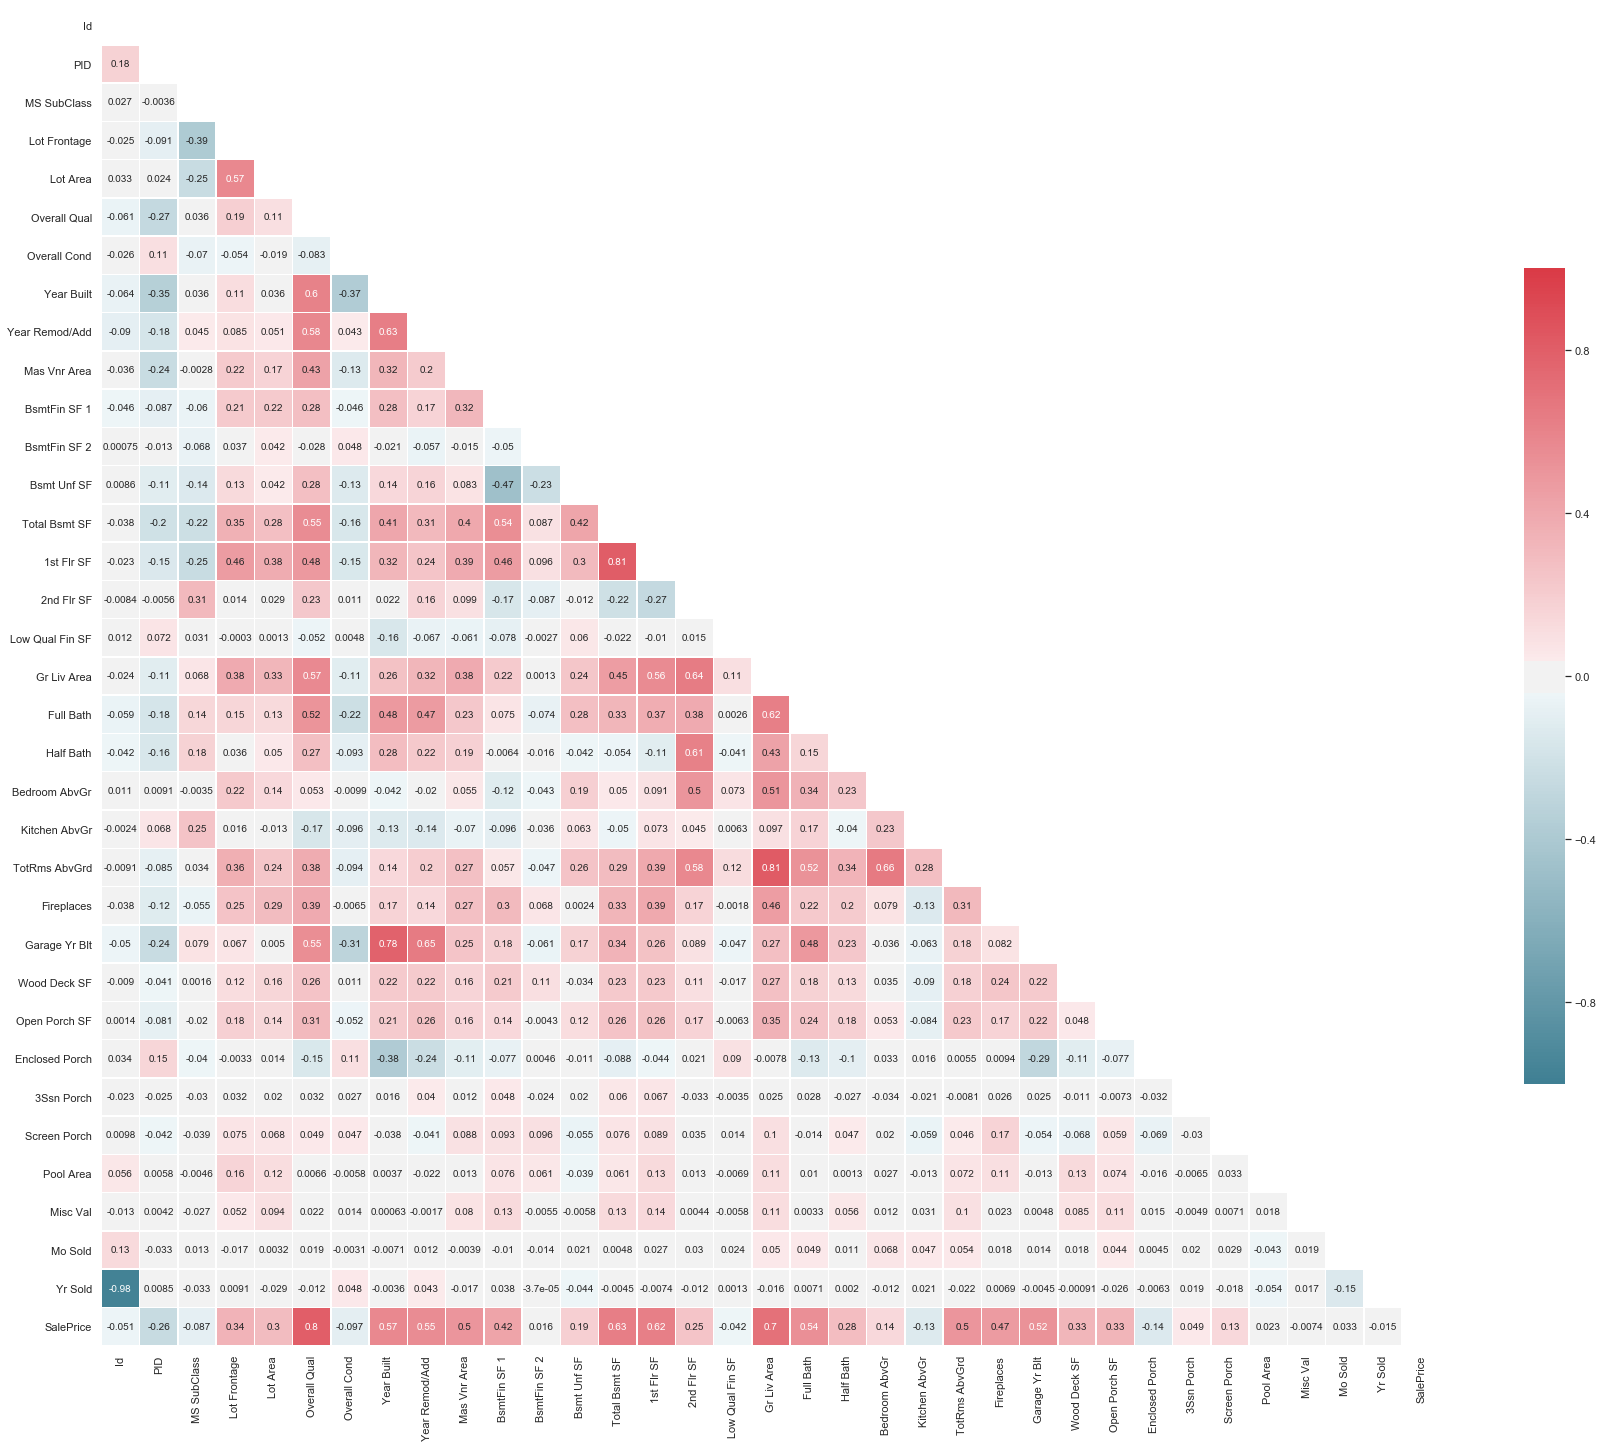

In [88]:
sns.set(style='white')
corr = ames_train_clean.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=1,vmin=-1,center=0,square=True,linewidths=.5,annot=True,annot_kws={'size':10},cbar_kws={'shrink':.5})

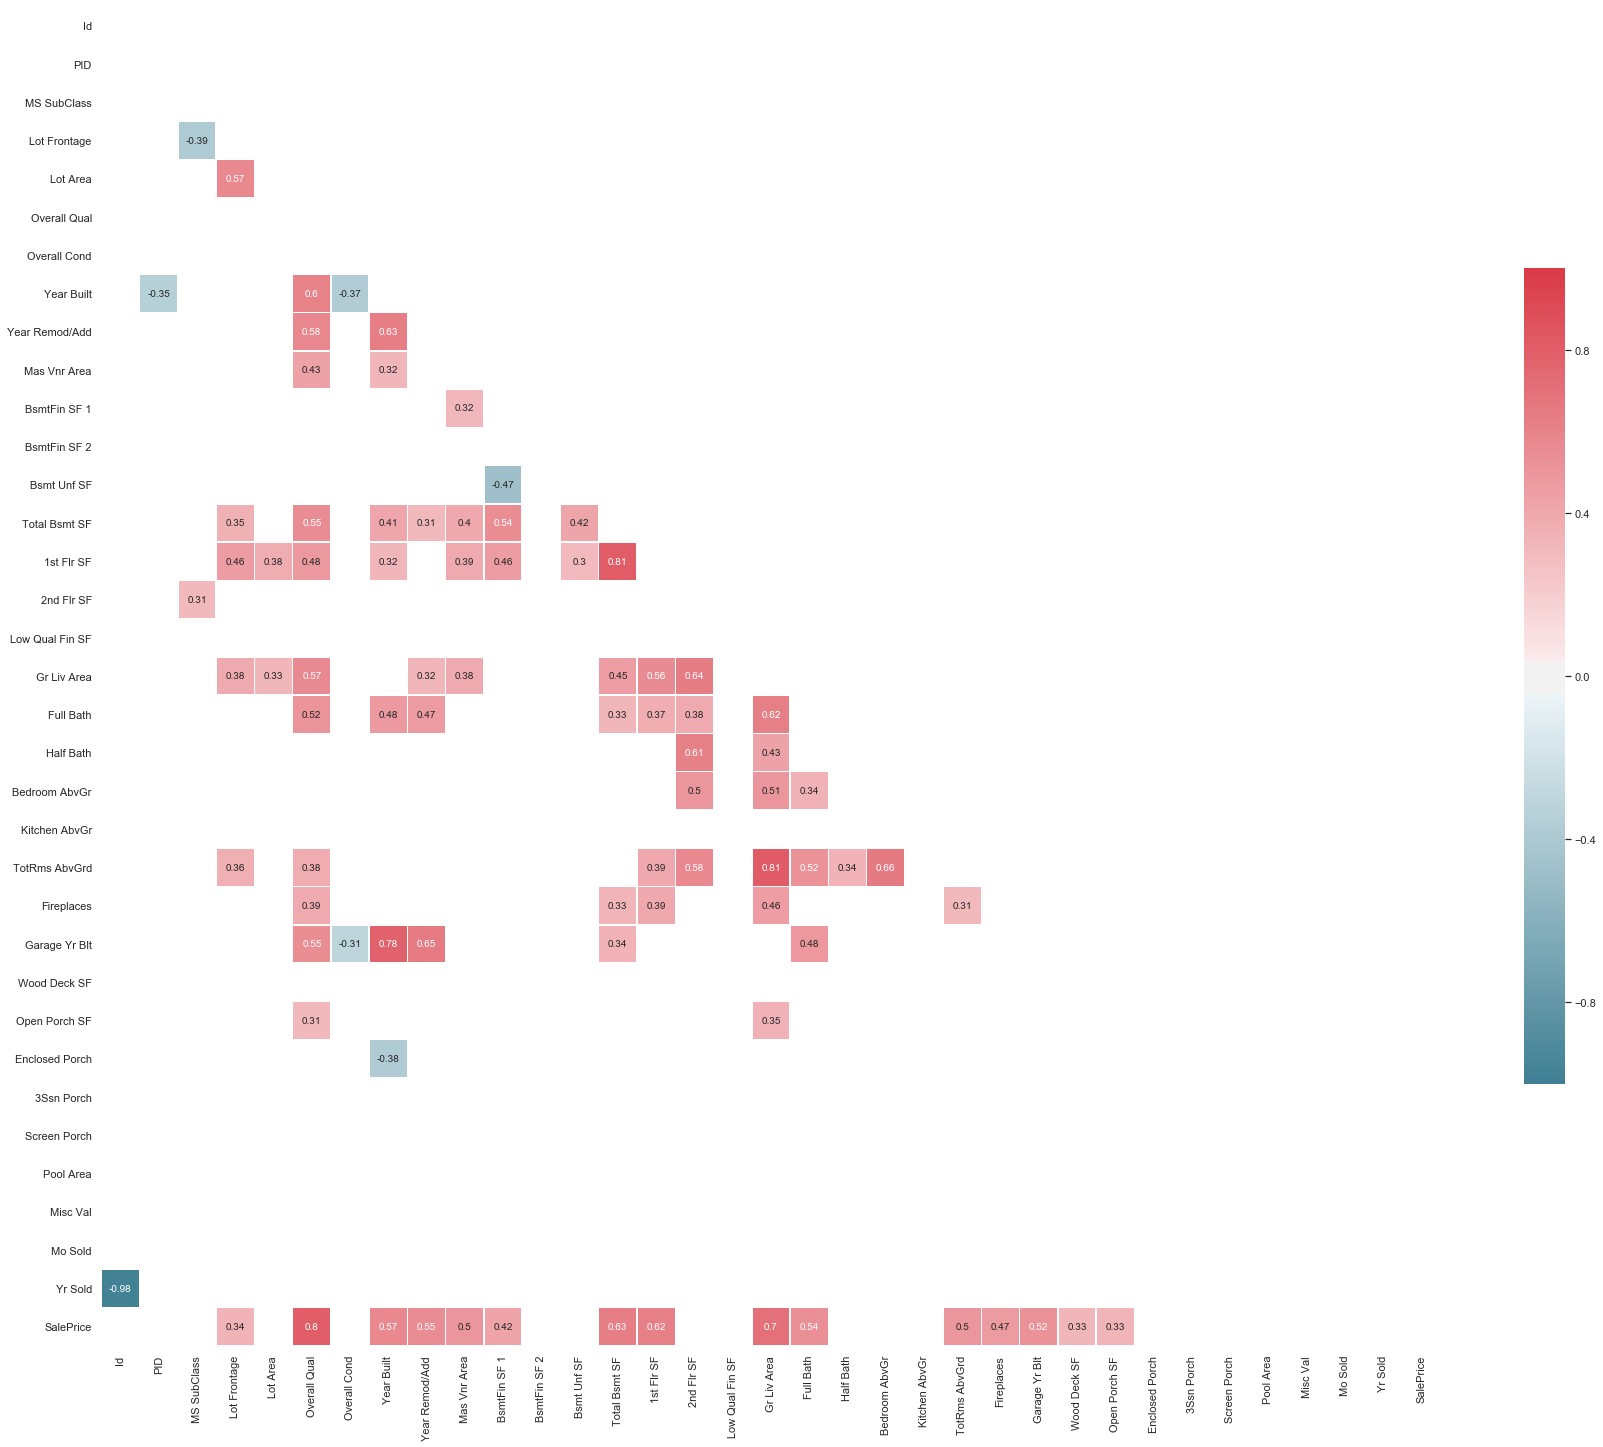

In [89]:
sns.set(style='white')
corr = ames_train_clean.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
abs_mask = mask | (np.abs(corr)<.3).values
f, ax = plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr,mask=abs_mask,cmap=cmap,vmax=1,vmin=-1,center=0,square=True,linewidths=.5,annot=True,annot_kws={'size':10},cbar_kws={'shrink':.5})

In [97]:
#we can see that 'Lot Frontage' has correlation with 'Lot Area', 'Total Bsmt SF', '1st Flr SF', 
#'Gr Liv Area', and 'TotRms AbvGr'. Let's run MICE.

XY_incomplete = ames_train_clean[['Lot Frontage','Lot Area','Total Bsmt SF', '1st Flr SF']]
n_imputations = 5
XY_completed  = []
for i in range(n_imputations):
    imputer = IterativeImputer(n_iter=5,sample_posterior=True,random_state=i)
    XY_completed.append(imputer.fit_transform(XY_incomplete))
    
XY_completed_mean = np.mean(XY_completed, 0)
XY_completed_std = np.std(XY_completed, 0)

ames_train_imputed = ames_train_clean.copy()
ames_train_imputed.loc[:,['Lot Frontage','Lot Area','Total Bsmt SF', '1st Flr SF']] = XY_completed_mean

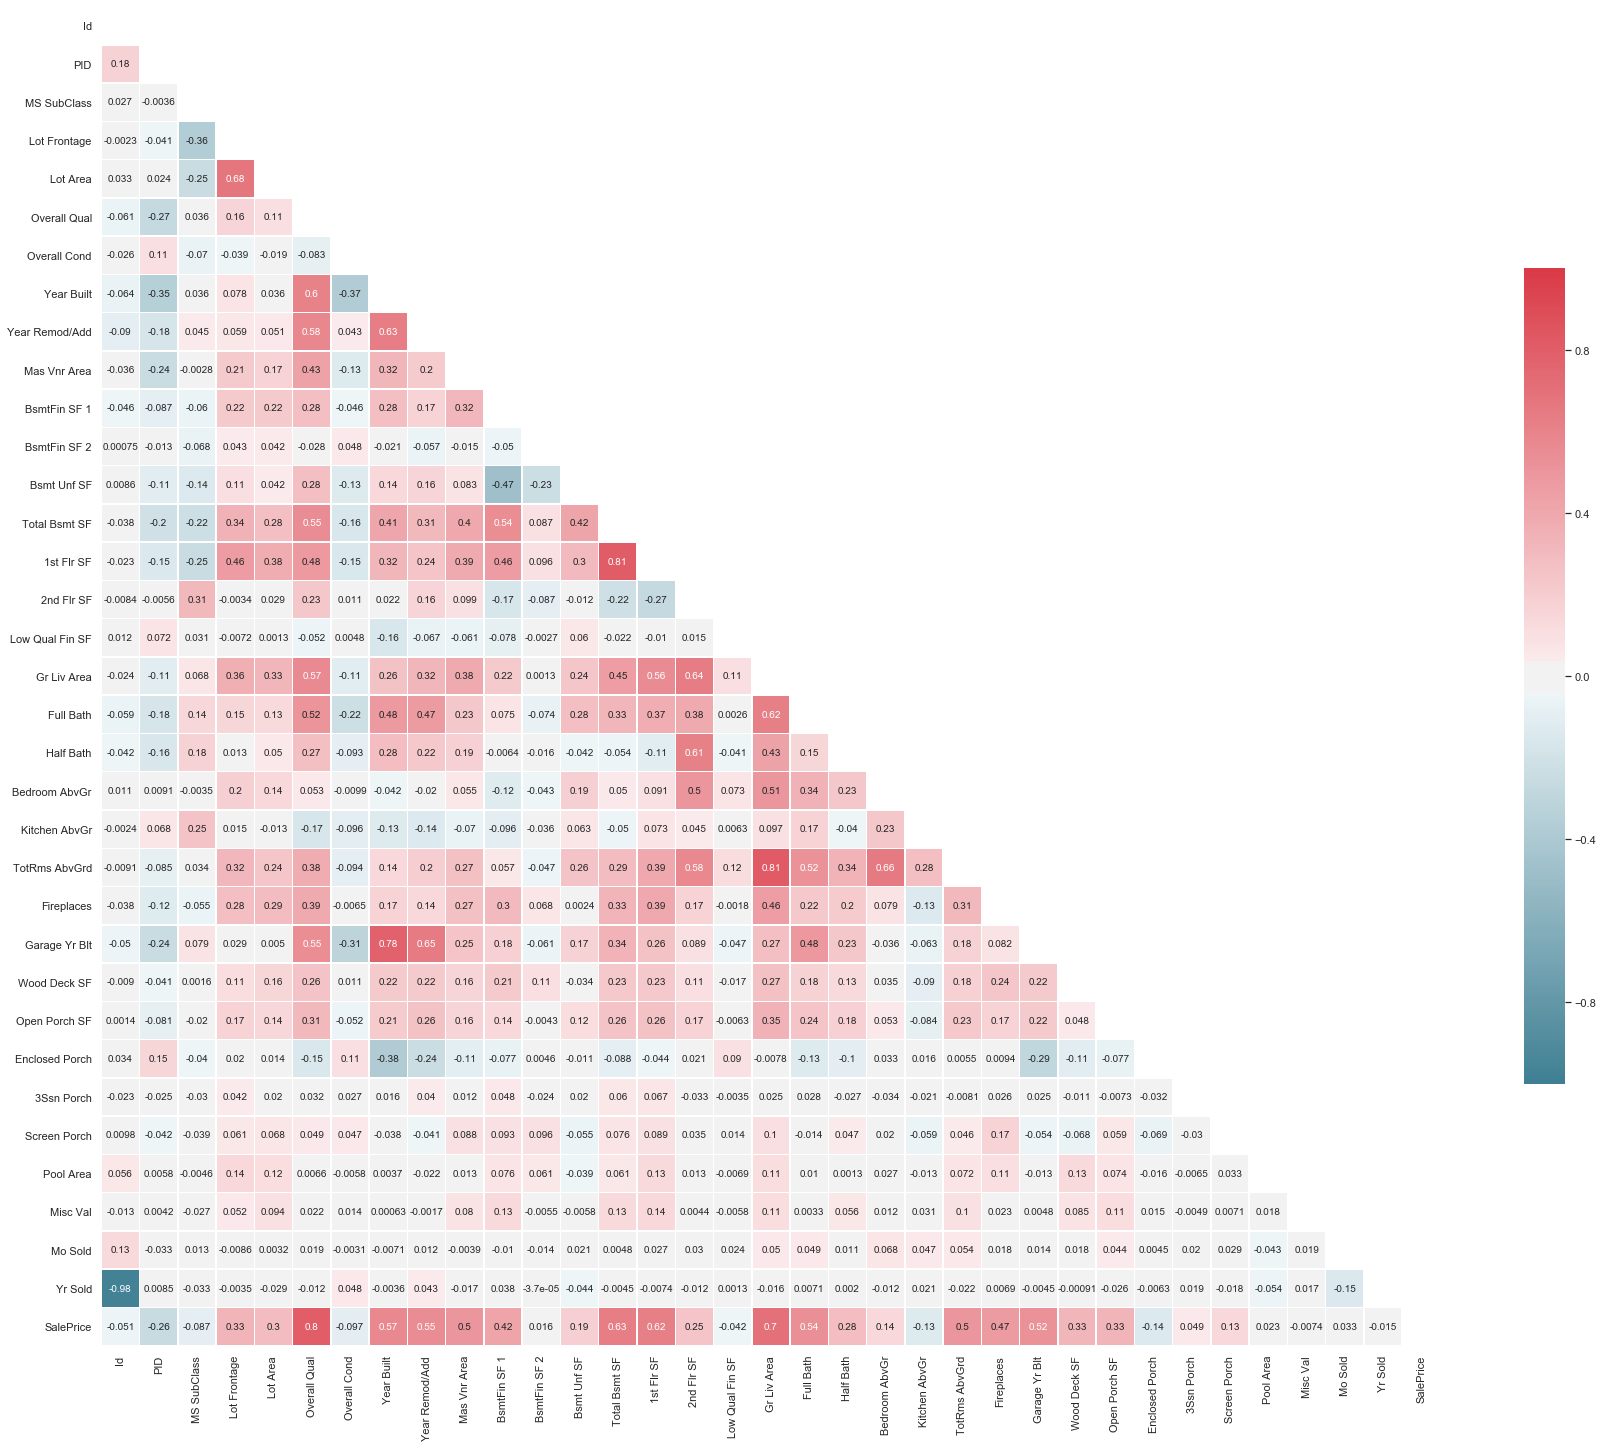

In [98]:
sns.set(style='white')
corr = ames_train_imputed.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=1,vmin=-1,center=0,square=True,linewidths=.5,annot=True,annot_kws={'size':10},cbar_kws={'shrink':.5})

In [ ]:
#just done for the heck of it. still relatively useless as the correlation to target variable is 0.33.

Order is a bit off, ended up spending too much time on imputing, also started really late. But here's what I would have done (and will do): on first pass, change dtypes, .describe(), fix low-hanging fruits. Then quick and dirty viz to fix any other outliers. Then some discussion on missingness of data and relevant imputation techniques. I really wanted to try other techniques for imputation such as KNN and MICE. Then another round of EDA and then feature engineering.

In [79]:
ames_train_clean.to_csv('../datasets/train_clean.csv')

In [80]:
ames_train_clean['MS Zoning'].value_counts()

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MS Zoning, dtype: int64